# What's So Funny?
## IS622 Final Project
### Brian Chu | December 20, 2015

Sense of humor is a tricky, if not impossible concept to quantify. Some argue that it is an abstract concept that cannot be measured, much like love and happiness. Others propose that context clues, cultural norms (3), or even biological traits contribute to the formula of funny.  
  
In this project, I look at sense of humor from the perspective of written jokes and try to see if commonalities can be discerned using collaborative filtering and content-based recommendation system techniques. A secondary objective is determining whether sense of humor can be better predicted by similarity with other persons or by specific joke features. Finally, I aim to improve on common recommendation system models by investigating a multi-stage approach using clustering.

In [1]:
import os
import sys

# Path for Spark source folder
os.environ['SPARK_HOME']="/home/brian/workspace/cuny_msda_is622/spark-1.5.1-bin-hadoop2.6"

# Append pyspark to Python Path
sys.path.append("/home/brian/workspace/cuny_msda_is622/spark-1.5.1-bin-hadoop2.6/python/")

# Append py4j to Python Path
sys.path.append("/home/brian/workspace/cuny_msda_is622/spark-1.5.1-bin-hadoop2.6/python/lib/py4j-0.8.2.1-src.zip")

# Launch Spark
execfile("/home/brian/workspace/cuny_msda_is622/spark-1.5.1-bin-hadoop2.6/python/pyspark/shell.py")

%qtconsole
%matplotlib inline

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.1
      /_/

Using Python version 2.7.10 (default, Oct 14 2015 16:09:02)
SparkContext available as sc, HiveContext available as sqlContext.


# Part 0: Load and clean data

In [2]:
# Load required packages
from pyspark.sql import SQLContext
import numpy as np
import pandas as pd
import math

### Dataset: Jester Online Joke Recommender System
**http://eigentaste.berkeley.edu/dataset/**  
Eigentaste: A Constant Time Collaborative Filtering Algorithm. Ken Goldberg, Theresa Roeder, Dhruv Gupta, and Chris Perkins. Information Retrieval, 4(2), 133-151. July 2001.  
  
This dataset includes 1,805,072 ratings on a scale of [-10, 10] of up to 100 jokes by 24,983 users.

In [3]:
jester = sc.textFile("jester2.csv")

# Create RDD, DataFrame, and Pandas objects
jrdd = jester.map(lambda line: line.split(","))
jdf = jrdd.toDF()

Recode missing data (99) to zeroes and normalize to 0 mean and 1 standard deviation.

In [4]:
from sklearn import preprocessing

jpd = jdf.toPandas()
jpd.iloc[:,1:] = jpd.iloc[:,1:].astype(float)
jpd[jpd == 99.] = 0
jpd.iloc[:,1:] = preprocessing.normalize(jpd.iloc[:,1:])

# Create PySpark dataframe
sqlc = SQLContext(sc)
jdf = sqlc.createDataFrame(jpd)

# Part 1: Collaborative Filtering Recommendations

### PySpark MLlib  
I am going to use PySpark's MLlib package, which incorporates collaborative filtering using the Alternating Least Squares (ALS) algorithm to predict missing entries. ALS aims to minimize the squared error of the UV user-item rating matrix by alternating learning sequences of U to V and V to U until a steady-state has been reached. This is similar to the collaborative filtering theory discussed in the MMS text.  
  
### Modified source code:  
http://spark.apache.org/docs/latest/mllib-collaborative-filtering.html  
https://databricks-training.s3.amazonaws.com/movie-recommendation-with-mllib.html

**MLlib ALS requires a Ratings object, which is a tuple in the format (userID, itemID, itemRating)**

In [8]:
# Create Ratings object required for MLlib ALS train function
# Exclude not rated entries for model training; will be used for testing and predicting

ratings = jdf.flatMap(lambda line: [(line[0], i, line[i]) for i in range(1,101) if line[i]!=0])

# View snippet of Ratings object
ratings.collect()[:5]

[(u'1', 1, -0.12541000876329006),
 (u'1', 2, 0.1409659817173043),
 (u'1', 3, -0.1549182461193583),
 (u'1', 4, -0.13086261783995484),
 (u'1', 5, -0.12059888310740936)]

**Check the number of users, jokes, and ratings in our dataframe**

In [9]:
numRatings = ratings.count()
numUsers = ratings.map(lambda r: r[0]).distinct().count()
numJokes = ratings.map(lambda r: r[1]).distinct().count()

print "Got %d ratings from %d users on %d jokes." % (numRatings, numUsers, numJokes)

Got 1805072 ratings from 24983 users on 100 jokes.


**Randomly divide ratings into a 75% training and 25% testing set**

In [10]:
ratingsTrain, ratingsTest = ratings.randomSplit([0.75, 0.25], seed = 85)

# Check number of ratings in each set
print "Rated Jokes for All Users"
print "Training set: %d" %(len(ratingsTrain.collect()))
print "Test set: %d" %(len(ratingsTest.collect()))

Rated Jokes for All Users
Training set: 1353794
Test set: 451278


### Train the recommendation model using ALS

In [11]:
from pyspark.mllib.recommendation import ALS, Rating

# Set parameters
rank = 5
numIterations = 10

# Train model with training data
cf_model = ALS.train(ratingsTrain, rank, numIterations)

**Check model accuracy and error**

In [12]:
ratingsTest = sc.parallelize(ratingsTest.collect())
cf_test = cf_model.predictAll(ratingsTest.map(lambda p: (p[0], p[1]))).map(lambda r: ((r[0], r[1]), r[2]))

# format [(userID, jokeID), (actual rating, predicted rating)]
cf_results = ratingsTest.map(lambda r: ((int(r[0]), r[1]), r[2])).join(cf_test)
cf_results = sc.parallelize(cf_results.collect())

# Example output
cf_results.collect()[:3]

[((5993, 77), (0.0704940933797176, -0.025000301990477758)),
 ((17350, 18), (0.17554646970416904, 0.0075514910891676945)),
 ((21952, 22), (0.10988728506862236, 0.07921825207622626))]

In [108]:
MSE_cf = cf_results.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print "Mean Squared Error = %.3f" %(MSE_cf)

RMSE_cf = math.sqrt(MSE)
print "Root Mean Squared Error = %.3f " %(RMSE_cf)

MAE_cf = cf_results.map(lambda r: abs((r[1][0] - r[1][1]))).mean()
print "Mean Absolute Error = %.3f" %(MAE_cf)

Mean Squared Error = 0.009
Root Mean Squared Error = 0.079 
Mean Absolute Error = 0.076


### Make recommendations using CF model and set of jokes not rated

In [14]:
# Separate out rated and not rated jokes for a specific user

def get_rated_notRated(user_num, ratings_all):
    
    jokeID = list(range(1, numJokes + 1))
    userID = str(user_num)

    # User's rated jokes
    uRatings = [(j,r) for (u,j,r) in ratings_all.collect() if u==userID]
    jokes_rated = [j[0] for j in uRatings]
    jokes_notRated = [j for j in jokeID if j not in jokes_rated]
    
    return (jokes_rated, jokes_notRated)

In [15]:
# Example
user = 1
u1 = get_rated_notRated(user, ratings)
print "Rated jokes: %d" %(len(u1[0]))
print "Unrated jokes: %d" %(len(u1[1]))

Rated jokes: 74
Unrated jokes: 26


#### Predicted ratings

In [16]:
# Get predicted ratings for jokes not previously rated

def get_cf_recs(user, unratedIDs, model):
    
    unratedIDs = sc.parallelize(set(unratedIDs))
    cf_predictions = model.predictAll(unratedIDs.map(lambda x: (user, x))).collect()
    cf_predictions = sorted(cf_predictions, key=lambda k: k[2], reverse=True)
    
    return cf_predictions

In [17]:
# Blank dictionary to hold all CF recommendations for all users
cf_recs = {}

In [18]:
# Example - top 5 recommendations for User 13
user_num = 13
user_rated, user_notRated = get_rated_notRated(user_num, ratings)

if user_notRated:
    cf_recs[user_num] = get_cf_recs(user_num, user_notRated, cf_model)
    print "Recommended jokes for User %d (score out of 10): \n" %(user_num)
    for i in cf_recs[user_num][:5]:
        print "JokeID: %d    Predicted rating: %.2f" %(i[1], i[2])
else: 
    print "No unrated jokes for User %d" %(user_num)

Recommended jokes for User 13 (score out of 10): 

JokeID: 89    Predicted rating: 0.15
JokeID: 72    Predicted rating: 0.14
JokeID: 76    Predicted rating: 0.12
JokeID: 83    Predicted rating: 0.12
JokeID: 12    Predicted rating: 0.12


**Print full joke of the top 5 recommendations**

In [19]:
import pickle
jokesFull = pickle.load(open( "jokesFull.p", "rb" ) )

In [20]:
user_num = 13
for i in cf_recs[user_num][:5]:
    print "Joke #%d:" %(i[1])
    print jokesFull[i[1]] +"\n"

Joke #89:
Q: How many programmers does it take to change a lightbulb? A: NONE! That's a hardware problem. . . .

Joke #72:
Q: What is the difference between George Washington,  Richard Nixon,  and Bill Clinton? A: Washington couldn't tell a lie,  Nixon couldn't tell the truth,  and Clinton doesn't know the difference.

Joke #76:
If pro- is the opposite of con- then congress must be the opposite of progress.

Joke #83:
Q: What is the difference between Mechanical Engineers and Civil Engineers? A: Mechanical Engineers build weapons,  Civil Engineers build targets.

Joke #12:
They asked the Japanese visitor if they have elections in his country.  "Every Morning" he answers.



# Part 2: Content-Based Recommendations 
### Create Item (Joke) Profile

#### Get corpus of jokes (documents)
* Use cleaned jokes stripped of stopwords and punctuation for better classification

In [21]:
jokesClean = pickle.load(open( "jokesClean.p", "rb" ) )

# Assemble corpus as one file, split by new line
with open('jokesClean.txt', 'w') as jc:
    for k,v in jokesClean.iteritems():
      jc.write("%s\n" % v)

In [22]:
# Load into Spark - should have 100 jokes
documents = sc.textFile("jokesClean.txt").map(lambda line: line.split(" "))
documents.count()

100

#### Feature extraction - use PySpark's tf.idf function  

http://spark.apache.org/docs/latest/mllib-feature-extraction.html#tf-idf

In [23]:
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import IDF

hashingTF = HashingTF()
tf = hashingTF.transform(documents)

tf.cache()
idf = IDF().fit(tf)
tfidf = idf.transform(tf)

In [24]:
# Example
joke_features = tfidf.collect()
joke_features[0]

SparseVector(1048576, {47054: 3.922, 183558: 7.8439, 285677: 3.922, 397847: 2.2172, 419033: 3.0057, 518276: 1.2478, 582313: 3.5165, 605676: 2.4179, 608735: 3.5638, 611077: 2.3125, 640114: 3.2288, 641573: 3.922, 904615: 6.4577, 985518: 3.922})

#### Calculate cosine similarity

In [25]:
import math
def cosine_similarity(v1, v2):
    dotprod = v1.dot(v2)
    sqdist = v1.squared_distance(v2)
    cosine_angle = dotprod / sqdist
    
    try:
        cosine_distance = math.acos(cosine_angle) * (180/math.pi)
    except:
        cosine_distance = 90.0
    
#     return np.round(cosine_distance, 2)
    return np.round(cosine_angle, 5)

In [26]:
# Test using PySpark sparse vectors
sv1 = Vectors.sparse(3, [0,1,2], [1.0,2.0,-1.0])
sv2 = Vectors.sparse(3, [0,1,2], [2.0,1.0,1.0])
print cosine_similarity(sv1, sv2) # should be 0.5

0.5


In [27]:
# Example cosine distance Joke 1 and 87
print cosine_similarity(joke_features[0], joke_features[86])

0.20842


In [28]:
print jokesFull[0]
print
print jokesFull[86]

A man visits the doctor.  The doctor says "I have bad news for you. You have cancer and Alzheimer's disease".  The man replies "Well, thank God I don't have cancer!"

A man,  recently completing a routine physical examination receives a phone call from his doctor.  The doctor says,  "I have some good news and some bad news. " The man says,  "OK,  give me the good news first. " The doctor says,  "The good news is,  you have 24 hours to live. " The man replies,  "Shit! That's the good news? Then what's the bad news?" The doctor says,  "The bad news is,  I forgot to call you yesterday. "


> Model seems good, both jokes relate to medical humor

### Create User Profile  

* Weight each joke's features by user rating
* Output sparse vector of user's feature rating preference

In [29]:
# Function to add two sparse vectors together - needed to aggregate user features for all jokes
# Source: http://stackoverflow.com/questions/32981875/how-to-add-two-sparse-vectors-in-spark-using-python

from pyspark.mllib.linalg import SparseVector, DenseVector

def add(v1, v2):
    """Add two sparse vectors
    >>> v1 = Vectors.sparse(3, {0: 1.0, 2: 1.0})
    >>> v2 = Vectors.sparse(3, {1: 1.0})
    >>> add(v1, v2)
    SparseVector(3, {0: 1.0, 1: 1.0, 2: 1.0})
    """
    assert isinstance(v1, SparseVector) and isinstance(v2, SparseVector)
    assert v1.size == v2.size 
    # Compute union of indices
    indices = set(v1.indices).union(set(v2.indices))
    # Not particularly efficient but we are limited by SPARK-10973
    # Create index: value dicts
    v1d = dict(zip(v1.indices, v1.values))
    v2d = dict(zip(v2.indices, v2.values))
    zero = np.float64(0)
    # Create dictionary index: (v1[index] + v2[index])
    values =  {i: v1d.get(i, zero) + v2d.get(i, zero)
       for i in indices
       if v1d.get(i, zero) + v2d.get(i, zero) != zero}

    return Vectors.sparse(v1.size, values)

SparseVector.__add__ = add

In [30]:
# User profile based on rated jokes
def get_user_profile(user_num):
    features = tfidf.collect()
    user_profile = features[0]
    user_ratings = jdf.collect()[user_num - 1]
    for i in range(1, len(features)):
        if user_ratings[i] != 0:
            features[i].values = features[i].values * user_ratings[i+1]
            user_profile = user_profile + features[i]
    return user_profile

### Make content-based recommendations  
* Aggregate user-item profiles for a specified user

In [57]:
# Content-based recommendations
def get_content_recs(user_profile, user_notRated):
    
    # Similarity - all jokes
    similarity_all = [{i+1 : cosine_similarity(joke_features[i], user_profile)} for i in range(len(jokesFull))]

    # Similarity - not rated jokes only
    notRated = sc.parallelize(set(user_notRated))
    similarity_notRated = notRated.map(lambda x: (x, similarity_all[x-1][x])).collect()
    similarity_notRated = sorted(similarity_notRated , key=lambda k: k[1], reverse=True)
    return similarity_notRated

In [35]:
# Blank dictionary to hold all CB recommendations for all users
content_recs = {}

In [58]:
# Example - top 5 recommendations for User 13
user_num = 13
user_rated, user_notRated = get_rated_notRated(user_num, ratings)

if user_notRated:
    up = get_user_profile(user_num)
    content_recs[user_num] = get_content_recs(up, user_notRated)
    print "Recommended jokes for User %d: \n" %(user_num)
    for i in content_recs[user_num][:5]:       
        print "JokeID: %d    Similarity distance: %.2f" %(i[0], i[1])
else: 
    print "No unrated jokes for User %d" %(user_num)

Recommended jokes for User 13: 

JokeID: 1    Similarity distance: 0.35
JokeID: 87    Similarity distance: 0.17
JokeID: 92    Similarity distance: 0.07
JokeID: 76    Similarity distance: 0.07
JokeID: 88    Similarity distance: 0.06


** Recommended jokes**

In [60]:
user_num = 13
for i in content_recs[user_num][1:5]:
    print "Joke #%d:" %(i[0])
    print jokesFull[i[0]] +"\n"

Joke #87:
A Czechoslovakian man felt his eyesight was growing steadily worse,  and felt it was time to go see an optometrist.  The doctor started with some simple testing,  and showed him a standard eye chart with letters of diminishing size: CRKBNWXSKZY.  .  .  "Can you read this?" the doctor asked.  "Read it?" the Czech answered.  "Doc,  I know him!"

Joke #92:
Reaching the end of a job interview,  the human resources person asked a young engineer fresh out of Stanford,  "And what starting salary were you looking for?" The engineer said,  "In the neighborhood of $125, 000 a year,  depending on the benefits package. " The interviewer said,  "Well,  what would you say to a package of 5-weeks vacation,  14 paid holidays,  full medical and dental,  company matching retirement fund to 50% of salary,  and a company car leased every 2 years - say,  a red Corvette?" The Engineer sat up straight and said,  "Wow! Are you kidding?" And the interviewer replied,  "Yeah,  but you started it. "

Jo

# Part 3: Compare CF and CB

In [38]:
# Divide ratings into test and training set
user_num = 13
rall = ratings.filter(lambda x: x[0]==str(user_num))

rtrain, rtest = rall.randomSplit([0.75, 0.25], seed = 85)
rtrainIDs = [x[1] for x in rtrain.collect()]
rtestIDs = [x[1] for x in rtest.collect()]

print "Rated Jokes for User %d\n" %(user_num)
print "Total rated: %d" %(rall.count())
print "Training set: %d" %(len(rtrainIDs))
print "Test set: %d" %(len(rtestIDs))

Rated Jokes for User 13

Total rated: 47
Training set: 37
Test set: 10


In [39]:
# Top N recommendations 

N = 0.5 # N percent of test set to recommend
n = int(math.ceil(N * len(rtestIDs)))
n

5

### Get Actual Test Set Top N Recommendations

In [40]:
# Get top test set results based on actual ratings
def get_actual_rec(test_set, n):
    test_set = test_set.sortBy(lambda x: x[2], ascending=False)
    test_IDs = [x[1] for x in test_set.collect()]
    top_IDs = [x[1] for x in test_set.collect()[:n]]
    return top_IDs

In [41]:
topTestIDs = get_actual_rec(rtest, n)
print topTestIDs

[49, 36, 93, 45, 28]


### Get Collaborative Filtering Top N Recommendations

In [42]:
# Get top CF recommendations
compare_cf = get_cf_recs(user_num, rtestIDs, cf_model)
topCFIDs = [x[1] for x in compare_cf[:n]]
print topCFIDs

[36, 49, 42, 93, 28]


### Get Content-based Top N Recommendations

In [43]:
# Update user profile function for train/test purposes
# Remove testIDs from user profile since they are equal to 'not rated'
def get_user_profile_topN(user_num, testIDs):
    features = tfidf.collect()
    user_profile = features[0]
    user_ratings = jdf.collect()[user_num - 1]
    for i in range(1, len(features)):
        if (user_ratings[i] != 0 and i not in testIDs):
            features[i].values = features[i].values * user_ratings[i+1]
            user_profile = user_profile + features[i]
    return user_profile

In [61]:
# Get top content-based recommendations
up_comp = get_user_profile_topN(user_num, rtestIDs)
compare_content = get_content_recs(up_comp, rtestIDs)
topContentIDs = [x[0] for x in compare_content[:n]]
print topContentIDs

[28, 49, 63, 36, 45]


### Wrap all of the above into one function

In [45]:
def make_traintest_sets(ratings_base, user_num):
    
    rall = ratings_base.filter(lambda x: x[0]==str(user_num))
    rtrain, rtest = rall.randomSplit([0.75, 0.25], seed = 85)
    rtrainIDs = [x[1] for x in rtrain.collect()]
    rtestIDs = [x[1] for x in rtest.collect()]

    return(rtrain, rtrainIDs, rtest, rtestIDs)

def get_top_recommendations(user_num, rtest, rtestIDs, N):
    
    # N recommendations to return
    n = int(math.ceil(N * len(rtestIDs)))
    
    # top Test
    topTestIDs = get_actual_rec(rtest, n)
    
    # top CF
    compare_cf = get_cf_recs(user_num, rtestIDs, cf_model)
    topCFIDs = [x[1] for x in compare_cf[:n]]
    
    # top CB
    up_comp = get_user_profile_topN(user_num, rtestIDs)
    compare_content = get_content_recs(up_comp, rtestIDs)
    topContentIDs = [x[0] for x in compare_content[:n]]
    
    return(topTestIDs, topCFIDs, topContentIDs)
    

In [62]:
user_num = 13
trainSet, trainIDs, testSet, testIDs = make_traintest_sets(ratings, user_num)
topTestIDs, topCFIDs, topContentIDs = get_top_recommendations(user_num, testSet, testIDs, 0.5)

print topTestIDs
print topCFIDs
print topContentIDs

[49, 36, 93, 45, 28]
[36, 49, 42, 93, 28]
[28, 49, 63, 36, 45]


## Accuracy Scores

** Use precision, recall, and F1 to compare recommendation systems **

**<a href="http://grouplens.org/site-content/uploads/evaluating-TOIS-20041.pdf">Evaluating collaborative filtering recommender systems (2004)</a>**  
Jonathan L. Herlocker , Joseph A. Konstan , Loren G. Terveen , John T. Riedl  
  
**<a href="http://research.microsoft.com/pubs/115396/EvaluationMetrics.TR.pdf">Evaluating Recommendation Systems</a>**  
Guy Shani and Asela Gunawardana

In [47]:
# Recommendation precision, recallm, F1-score
import sklearn.metrics as sm

def get_rec_accuracy(testRecs, compRecs, numTest, rec_rank=False):
    
    # Recommendation rank does not matter
    if rec_rank:
        
        rec_precision = sm.precision_score(np.array(testRecs), np.array(compRecs), average='macro')
        rec_recall = np.round((rec_precision * len(testRecs)) / float(numTest), 2)
        rec_f1 = np.round((2 * rec_precision * rec_recall) / (rec_precision + rec_recall), 2)   

    # Recommendation rank matters
    else:    
        matches = list(set(testRecs).intersection(compRecs))
        rec_precision = np.round(len(matches) / float(len(testRecs)), 2)
        rec_recall = np.round(len(matches) / float(numTest), 2)
        rec_f1 = np.round((2 * rec_precision * rec_recall) / (rec_precision + rec_recall), 2)
        
    if np.isnan(rec_f1):
        rec_f1 = 0
    
    return (rec_precision, rec_recall, rec_f1)

### Collaborative filtering accuracy

In [49]:
# Collaborative filtering accuracy
numTest = len(testIDs)
user_num = 13

precisionCF, recallCF, f1CF = get_rec_accuracy(topTestIDs, topCFIDs, numTest, rec_rank=False)
print "User %d\n" %user_num
print "Collaborative Filtering Accuracy - Excluding Recommendation Rank"
print "Precision: %.2f" %precisionCF
print "Recall: %.2f" %recallCF
print "F1 score: %.2f\n" %f1CF

precisionCF_rank, recallCF_rank, f1CF_rank = get_rec_accuracy(topTestIDs, topCFIDs, numTest, rec_rank=True)
print "Collaborative Filtering Accuracy - Including Recommendation Rank"
print "Precision: %.2f" %precisionCF_rank
print "Recall: %.2f" %recallCF_rank
print "F1 score: %.2f\n" %f1CF_rank

User 13

Collaborative Filtering Accuracy - Excluding Recommendation Rank
Precision: 0.80
Recall: 0.40
F1 score: 0.53

Collaborative Filtering Accuracy - Including Recommendation Rank
Precision: 0.17
Recall: 0.08
F1 score: 0.11



### Content-based accuracy

In [50]:
# Content-based accuracy
numTest = len(testIDs)

precisionContent, recallContent, f1Content = get_rec_accuracy(topTestIDs, topContentIDs, numTest, rec_rank=False)
print "User %d\n" %user_num
print "Content-based Accuracy - Excluding Recommendation Rank"
print "Precision: %.2f" %precisionContent
print "Recall: %.2f" %recallContent
print "F1 score: %.2f\n" %f1Content

precisionContent_rank, recallContent_rank, f1Content_rank = get_rec_accuracy(topTestIDs, topContentIDs, numTest, rec_rank=True)
print "Content-based Accuracy - Including Recommendation Rank"
print "Precision: %.2f" %precisionContent_rank
print "Recall: %.2f" %recallContent_rank
print "F1 score: %.2f\n" %f1Content_rank

User 13

Content-based Accuracy - Excluding Recommendation Rank
Precision: 0.20
Recall: 0.10
F1 score: 0.13

Content-based Accuracy - Including Recommendation Rank
Precision: 0.00
Recall: 0.00
F1 score: 0.00



### Compare Precision, Recall, F1 Score

In [63]:
import random
users = range(1, numUsers + 1)
random.shuffle(users)
users = users[:50]

#### Compare based off top 25% of recommendations

In [65]:
CFCB_accuracy_25 = pd.DataFrame(index=users, columns=['precision_cf', 'recall_cf', 'f1_cf', 
                                                  'precision_cb', 'recall_cb', 'f1_cb'])

topN = 0.25 #top N percent of recommendations
for u in users:
    trainSet, trainIDs, testSet, testIDs = make_traintest_sets(ratings, u)
    topTestIDs, topCFIDs, topContentIDs = get_top_recommendations(u, testSet, testIDs, topN)
    num_test = len(testIDs)
    pcf, rcf, f1cf = get_rec_accuracy(topTestIDs, topCFIDs, num_test, rec_rank=False)
    pcb, rcb, f1cb = get_rec_accuracy(topTestIDs, topContentIDs, num_test, rec_rank=False)
    
    CFCB_accuracy_25.ix[u] = np.array([pcf, rcf, f1cf, pcb, rcb, f1cb])  

In [69]:
# Average accuracy scores
CFCB_mean25 = pd.DataFrame(CFCB_accuracy_25.mean(axis=0), columns=["Top_25%"])
CFCB_mean25

,Top_25%
precision_cf,0.4684
recall_cf,0.1350
f1_cf,0.2086
precision_cb,0.5354
recall_cb,0.1524
f1_cb,0.2362


#### Repeat for N = top 50%

In [70]:
CFCB_accuracy_50 = pd.DataFrame(index=users, columns=['precision_cf', 'recall_cf', 'f1_cf', 
                                                  'precision_cb', 'recall_cb', 'f1_cb'])

topN = 0.50 #top N percent of recommendations
for u in users:
    trainSet, trainIDs, testSet, testIDs = make_traintest_sets(ratings, u)
    topTestIDs, topCFIDs, topContentIDs = get_top_recommendations(u, testSet, testIDs, topN)
    num_test = len(testIDs)
    pcf, rcf, f1cf = get_rec_accuracy(topTestIDs, topCFIDs, num_test, rec_rank=False)
    pcb, rcb, f1cb = get_rec_accuracy(topTestIDs, topContentIDs, num_test, rec_rank=False)
    
    CFCB_accuracy_50.ix[u] = np.array([pcf, rcf, f1cf, pcb, rcb, f1cb])  

In [77]:
# Average accuracy scores
CFCB_mean50 = pd.DataFrame(CFCB_accuracy_50.mean(axis=0), columns=["Top_50%"])
CFCB_mean50

,Top_50%
precision_cf,0.6664
recall_cf,0.3458
f1_cf,0.4554
precision_cb,0.7162
recall_cb,0.3710
f1_cb,0.4890


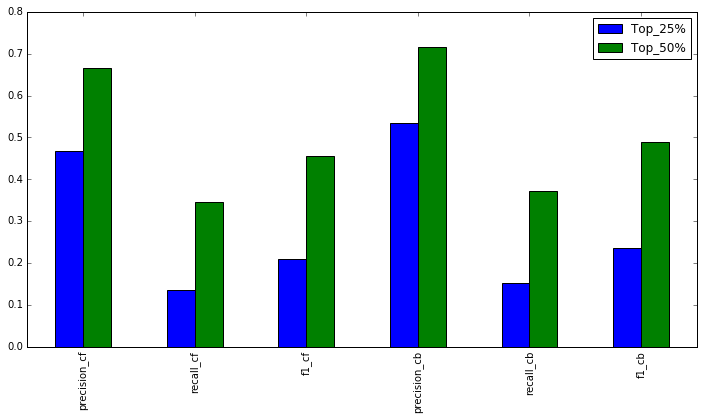

In [83]:
%matplotlib inline

CFCB_compare = CFCB_mean25.merge(CFCB_mean50,left_index=True, right_index=True)
CFCB_compare.plot(kind='bar', figsize=[12,6])

Very interesting that CB outperformed CF on all measures. Let's try a two-stage approach involving clustering.

# Part 4: Two-Stage Model with Clustering

## K-means

### K-means cluster jokes

In [85]:
jpd_kmeans_jokes = jpd.iloc[:,1:].transpose()
jdf_kmeans_jokes = sqlc.createDataFrame(jpd_kmeans_jokes)

In [88]:
# Source: http://spark.apache.org/docs/latest/mllib-clustering.html

from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array

k = 5
jokes_kmeans = jdf_kmeans_jokes.map(lambda row: array([x for x in row]))
jokes_clusters = KMeans.train(jokes_kmeans, k, maxIterations=10, seed=55)

In [90]:
# Predict cluster of each user
jokes_kmeans_predict = jokes_clusters.predict(jokes_kmeans).take(jokes_kmeans.count())

# Examine output
from collections import Counter
print jokes_kmeans_predict[0]
print(Counter(jokes_kmeans_predict))

2
Counter({2: 63, 0: 34, 1: 1, 3: 1, 4: 1})


In [91]:
# Sum of squares distance
jokes_clusters.computeCost(jokes_kmeans)

17584.067350474736

It doesn't seem very suitable to cluster based on jokes. Joke features are too sparse and computationally expensive, while ratings don't produce very even-weighted clusters. Let's try clustering users instead.

### K-means cluster users

In [92]:
jpd_kmeans_user = jpd.iloc[:,1:]
jdf_kmeans_user = sqlc.createDataFrame(jpd_kmeans_user)

In [93]:
k = 10 # number of clusters
user_kmeans = jdf_kmeans_user.map(lambda row: array([x for x in row]))
user_clusters = KMeans.train(user_kmeans, k, maxIterations=10, seed=55)

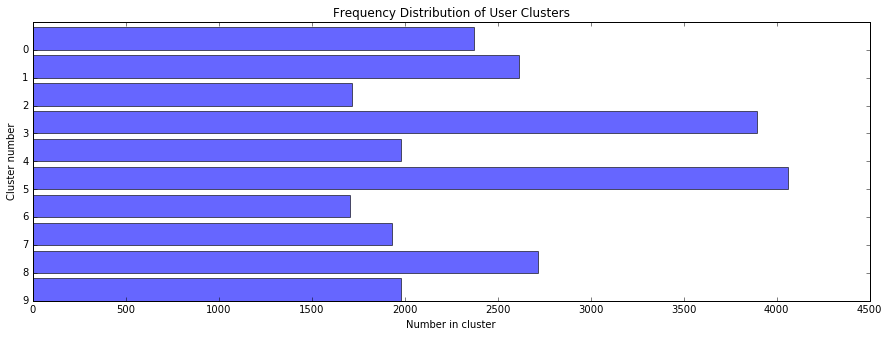

In [96]:
# Predict cluster of each user
user_kmeans_predict = user_clusters.predict(user_kmeans).take(user_kmeans.count())

# Examine output
kfreq = Counter(user_kmeans_predict)

# http://matplotlib.org/examples/lines_bars_and_markers/barh_demo.html
import matplotlib.pyplot as plt
import numpy as np

cluster = kfreq.keys()
y = np.arange(len(cluster))[::-1]
freq = kfreq.values()

plt.figure(figsize=[15,5])
plt.barh(y, freq, alpha=0.6)
plt.yticks(y, cluster)
plt.xlabel('Number in cluster')
plt.ylabel('Cluster number')
plt.title('Frequency Distribution of User Clusters')

plt.show()

In [97]:
# Sum of squares distance
user_clusters.computeCost(user_kmeans)

16987.183085482116

### Latent Dirichlet Allocation (LDA)

LDA is another clustering algorithm that extracts topic features, rather than the word features of TF.IDF from a corpus of documents. This would seemingly be helpful for our analysis as topics may be more informative than words for clustering jokes and identifying common features. Unfortunately, I ran into severe runtime and memory errors while executing the PySpark LDA implemementation. A separate attempt was made using SciPy’s sparse matrices, but that data structure was not compatible with PySpark. Some further notes and code attempts are in the appendix.

# Part 5: Combine Clustering with CF

K-means clustering on the user was the selected clustering method for the two-stage approach. After selecting the predicted cluster for the specified user, the CF model is re-trained using only users and ratings from that same cluster. The rest of the ALS model, however, remained the same. Likewise, the train-test set approach for error measurement and precision/recall/F1 approach for accuracy were consistent to allow for direct comparison with the CF-only model. 

In [98]:
# Get user cluster
user_num = 13
user_cluster = user_kmeans_predict[user_num - 1]
filteredIDs = [x[0]+1 for x in enumerate(user_kmeans_predict) if x[1] == user_cluster]

In [99]:
# Create new PySpark arrays based on cluster filter
jpd_filter = jpd.copy()
jdf_filter = sqlc.createDataFrame(jpd_filter)
jrdd_filter = jdf_filter.rdd

In [101]:
# Filter users by matching cluster only
combo_rdd = jrdd_filter.filter(lambda x: (int(x[0]) in filteredIDs))
combo_ratings = combo_rdd.flatMap(lambda line: [(line[0], i, line[i]) for i in range(1,101) if line[i]!=0])
print "Number of users in matching cluster: %d" %combo_ratings.count()

Number of users in matching cluster: 271195


In [102]:
# Retrain CF model based on filtered dataset
cAll = combo_ratings.filter(lambda x: int(x[0]) in filteredIDs)
cTrain, cTest = cAll.randomSplit([0.75, 0.25], seed = 85)
combo_model = ALS.train(cTrain, rank, numIterations)

### Accuracy of combined model

In [103]:
cTest = sc.parallelize(cTest.collect())
combo_predict = combo_model.predictAll(cTest.map(lambda p: (p[0], p[1]))).map(lambda r: ((r[0], r[1]), r[2]))

# [(userID, jokeID), (actual rating, predicted rating)]
combo_results = cTest.map(lambda r: ((int(r[0]), r[1]), r[2])).join(combo_predict)

# Example
combo_results.collect()[:3]

[((674, 48), (0.17266463395939652, 0.09892743551591324)),
 ((8516, 28), (0.14703175646904293, 0.12107734564946049)),
 ((21645, 13), (-0.08875312963324045, 0.023182066523742606))]

In [175]:
MSE_combo = combo_results.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print "Mean Squared Error = %.3f" %(MSE_combo)

RMSE_combo = math.sqrt(MSE_combo)
print "Root Mean Squared Error = %.3f" %(RMSE_combo)

MAE_combo = combo_results.map(lambda r: abs((r[1][0] - r[1][1]))).mean()
print "Mean Absolute Error = %.3f" %(MAE_combo)

Mean Squared Error = 0.006
Root Mean Squared Error = 0.079
Mean Absolute Error = 0.062


#### Comparison with CF-only Model

In [176]:
error_compare = pd.DataFrame([np.array([MSE_cf, RMSE_cf, MAE_cf]), 
                              np.array([MSE_combo, RMSE_combo, MAE_combo])], 
                 index = ['CF-only', 'Cluster+CF'],
                 columns = ['MSE', 'RMSE', 'MAE'] )

error_compare

,MSE,RMSE,MAE
CF-only,0.008884,0.079306,0.075771
Cluster+CF,0.006289,0.079306,0.061947


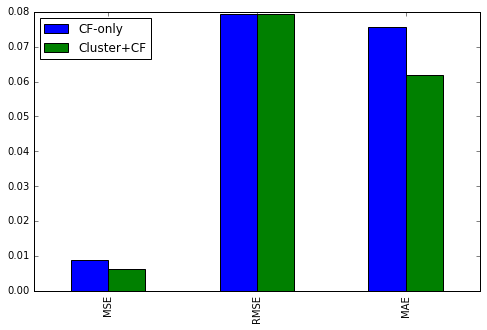

In [112]:
error_compare.transpose().plot(kind='bar', figsize=[8,5])

TODO: Comment on results

### Combined Model Recommendations

In [113]:
# Recommendations based on combo cluster-CF approach
user_num = 13
combo_ratedIDs, combo_notRatedIDs = get_rated_notRated(user_num, combo_ratings)

if combo_notRatedIDs:
    combo_recs = get_cf_recs(user_num, combo_notRatedIDs, combo_model)
    print "Recommended jokes for User %d (score out of 10): \n" %(user_num)
    for i in combo_recs[:5]:
        print "JokeID: %d    Predicted rating: %.2f" %(i[1], i[2])
else: 
    print "No unrated jokes for User %d" %(user_num)

Recommended jokes for User 13 (score out of 10): 

JokeID: 12    Predicted rating: 0.15
JokeID: 26    Predicted rating: 0.15
JokeID: 6    Predicted rating: 0.15
JokeID: 22    Predicted rating: 0.15
JokeID: 40    Predicted rating: 0.14


### CF-only Recommendations

In [114]:
# Example - top 5 recommendations for User 13
user_num = 13
user_rated, user_notRated = get_rated_notRated(user_num, ratings)

if user_notRated:
    cf_recs[user_num] = get_cf_recs(user_num, user_notRated, cf_model)
    print "Recommended jokes for User %d (score out of 10): \n" %(user_num)
    for i in cf_recs[user_num][:5]:
        print "JokeID: %d    Predicted rating: %.2f" %(i[1], i[2])
else: 
    print "No unrated jokes for User %d" %(user_num)

Recommended jokes for User 13 (score out of 10): 

JokeID: 89    Predicted rating: 0.15
JokeID: 72    Predicted rating: 0.14
JokeID: 76    Predicted rating: 0.12
JokeID: 83    Predicted rating: 0.12
JokeID: 12    Predicted rating: 0.12


We definitely see some different recommendation results from the two models.

### Recommendations - Test set and CF only

In [177]:
# All Recs
user_num = 13
trainSet, trainIDs, testSet, testIDs = make_traintest_sets(ratings, user_num)
topTestIDs, topCFIDs, topContentIDs = get_top_recommendations(user_num, testSet, testIDs, 0.5)

print topTestIDs
print topCFIDs

[49, 36, 93, 45, 28]
[36, 49, 42, 93, 28]


### Recommendations - Cluster + CF

In [117]:
# Redo train-test set functions to account for new model filtering out users

def make_traintest_sets_combo(ratings_base, user_num):
    
    rall = ratings_base.filter(lambda x: x[0]==str(user_num))
    rtest = rall.filter(lambda x: x[1] in testIDs)

    return rtest

def get_top_recs_combo(user_num,rtestIDs, N):
    
    # N recommendations to return
    n = int(math.ceil(N * len(rtestIDs)))
    
    # top Combo
    comboRecs = get_cf_recs(user_num, rtestIDs, combo_model)
    topComboIDs = [x[1] for x in comboRecs[:n]]
    
    return (comboRecs, topComboIDs)

In [118]:
comboTest = make_traintest_sets_combo(combo_ratings, user_num)
comboRecs, topComboIDs = get_top_recs_combo(user_num, testIDs, 0.5)
print topComboIDs

[36, 49, 42, 28, 45]


### CF-only accuracy

In [120]:
# Collaborative filtering accuracy
numTest = len(testIDs)
user_num = 13

precisionCF, recallCF, f1CF = get_rec_accuracy(topTestIDs, topCFIDs, numTest, rec_rank=False)
print "User %d\n" %user_num
print "Collaborative Filtering Accuracy - Excluding Recommendation Rank"
print "Precision: %.2f" %precisionCF
print "Recall: %.2f" %recallCF
print "F1 score: %.2f\n" %f1CF

precisionCF_rank, recallCF_rank, f1CF_rank = get_rec_accuracy(topTestIDs, topCFIDs, numTest, rec_rank=True)
print "Collaborative Filtering Accuracy - Including Recommendation Rank"
print "Precision: %.2f" %precisionCF_rank
print "Recall: %.2f" %recallCF_rank
print "F1 score: %.2f\n" %f1CF_rank

User 13

Collaborative Filtering Accuracy - Excluding Recommendation Rank
Precision: 0.80
Recall: 0.40
F1 score: 0.53

Collaborative Filtering Accuracy - Including Recommendation Rank
Precision: 0.17
Recall: 0.08
F1 score: 0.11



### Clustering + CF accuracy

In [119]:

numTest = len(testIDs)
user_num = 13

precisionCombo, recallCombo, f1Combo = get_rec_accuracy(topTestIDs, topComboIDs, numTest, rec_rank=False)
print "User %d\n" %user_num
print "Combo Cluster-CF Accuracy - Excluding Recommendation Rank"
print "Precision: %.2f" %precisionCombo
print "Recall: %.2f" %recallCombo
print "F1 score: %.2f\n" %f1Combo

precisionCombo_rank, recallCombo_rank, f1Combo_rank = get_rec_accuracy(topTestIDs, topComboIDs, numTest, rec_rank=True)
print "Combo Cluster-CF Accuracy - Including Recommendation Rank"
print "Precision: %.2f" %precisionCombo_rank
print "Recall: %.2f" %recallCombo_rank
print "F1 score: %.2f\n" %f1Combo_rank

User 13

Combo Cluster-CF Accuracy - Excluding Recommendation Rank
Precision: 0.80
Recall: 0.40
F1 score: 0.53

Combo Cluster-CF Accuracy - Including Recommendation Rank
Precision: 0.00
Recall: 0.00
F1 score: 0.00



### Compare Precision, Recall, F1 Score for CF-only vs. Cluster + CF

In [122]:
combo_accuracy_50 = pd.DataFrame(index=users2, columns=['precision_cf', 'recall_cf', 'f1_cf', 
                                                  'precision_combo', 'recall_combo', 'f1_combo'])

In [124]:
topN = 0.5 #top N percent of recommendations
for u in users:
    trainSet, trainIDs, testSet, testIDs = make_traintest_sets(ratings, u)
    topTestIDs, topCFIDs, topContentIDs = get_top_recommendations(u, testSet, testIDs, topN)
    comboRecs, topComboIDs = get_top_recs_combo(user_num, testIDs, topN)
    num_test = len(testIDs)
    pcf, rcf, f1cf = get_rec_accuracy(topTestIDs, topCFIDs, num_test, rec_rank=False)
    pcombo, rcombo, f1combo = get_rec_accuracy(topTestIDs, topComboIDs, num_test, rec_rank=False)
    
    combo_accuracy_50.ix[u] = np.array([pcf, rcf, f1cf, pcombo, rcombo, f1combo])  

In [179]:
# Average accuracy scores
combo_mean50 = pd.DataFrame(combo_accuracy_50.mean(axis=0), columns=["Top_50%"])

combo_compare = pd.DataFrame([np.array(combo_mean50.ix[0:3]).flatten(), np.array(combo_mean50.ix[3:6]).flatten()],
                            index = ['CF-only', 'Cluster+CF'], columns = ['Precision', 'Recall', 'F1'])
combo_compare

,Precision,Recall,F1
CF-only,0.6664,0.3458,0.4554
Cluster+CF,0.6058,0.3148,0.4132


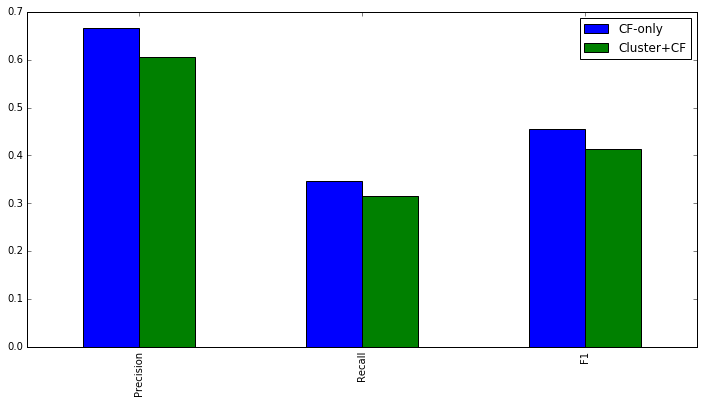

In [172]:
combo_compare.transpose().plot(kind='bar', figsize=[12,6])

Interestingly here, the results favored the CF-only model, which was surprising given the perceived error advantages of the combined approach. My guess is that both stages are effectively reducing the user matrix and the clustering pass may be overdoing it. Given more time, I would look at the effects of increasing the number of center points in the k-mean model.

# Appendix

## Timing Results

### TF.IDF feature extraction

In [193]:
%%capture

def time_tfidf(docs):
    hashingTF = HashingTF()
    tf = hashingTF.transform(docs)

    tf.cache()
    idf = IDF().fit(tf)
    tfidf = idf.transform(tf)

    return tfidf

%timeit -n 5 -o time_tfidf(documents)

<TimeitResult : 5 loops, best of 3: 233 ms per loop>

### CF train model

In [198]:
%%capture
%timeit -n 3 -o ALS.train(ratingsTrain, rank, numIterations)

<TimeitResult : 3 loops, best of 3: 13.9 s per loop>

### CF get recommendations

In [194]:
%%capture
%timeit -n 5 -o get_cf_recs(user_num, user_notRated, cf_model)

<TimeitResult : 5 loops, best of 3: 329 ms per loop>

### CB user-profile generation

In [195]:
%%capture
%timeit -n 5 -o get_user_profile(user_num)

<TimeitResult : 5 loops, best of 3: 1.54 s per loop>

### CB get recommendations

In [199]:
%%capture
%timeit -n 5 -o get_content_recs(up, user_notRated)

<TimeitResult : 5 loops, best of 3: 188 ms per loop>

### K-means clustering

In [201]:
%%capture

def kmeans_time(jokes_kmeans, k):
    jokes_clusters = KMeans.train(jokes_kmeans, k, maxIterations=10, seed=55)
    jokes_kmeans_predict = jokes_clusters.predict(jokes_kmeans).take(jokes_kmeans.count())
    return jokes_kmeans_predict 

%timeit -n 1 -o kmeans_time(jokes_kmeans , 5)

<TimeitResult : 1 loops, best of 3: 1min 48s per loop>

### Two-stage cluster and CF approach

In [200]:
%%capture
%timeit -n 5 -o get_top_recs_combo(user_num, testIDs, 0.5)

<TimeitResult : 5 loops, best of 3: 244 ms per loop>

## LDA clustering and feature extraction
Memory and runtime errors. Scipy implementation also could not convert sparse matrices to PySpark

In [ ]:
# LDA for joke features

# joke_features_par = sc.parallelize(joke_features)

# from pyspark.mllib.clustering import LDA, LDAModel
# from pyspark.mllib.linalg import Vectors

# # Load and parse the data
# # data = sc.textFile("/home/brian/workspace/cuny_msda_is622/spark-1.5.1-bin-hadoop2.6/data/mllib/sample_lda_data.txt")
# # parsedData = data.map(lambda line: Vectors.dense([float(x) for x in line.strip().split(' ')]))
# # Index documents with unique IDs

# corpus = joke_features_par.zipWithIndex().map(lambda x: [x[1], x[0]]).cache()

# # Cluster the documents into three topics using LDA
# ldaModel = LDA.train(corpus, k=3)

# # Output topics. Each is a distribution over words (matching word count vectors)
# print("Learned topics (as distributions over vocab of " + str(ldaModel.vocabSize()) + " words):")
# topics = ldaModel.topicsMatrix()
# for topic in range(3):
#     print("Topic " + str(topic) + ":")
#     for word in range(0, ldaModel.vocabSize()):
#         print(" " + str(topics[word][topic]))

In [ ]:
# Use Scikit-learn to make feature matrix, convert to PySpark
# from sklearn.feature_extraction.text import TfidfVectorizer
# textfile = open("jokesClean.txt", "rb")
# docs = textfile.read().split('\n')
# del docs[-1]
# vectorizer = TfidfVectorizer(min_df=1)
# docs_tfidf = vectorizer.fit_transform(docs)
# from sklearn.metrics.pairwise import cosine_similarity
# cs = cosine_similarity(docs_tfidf[0:1], docs_tfidf)
# print cs
# type(docs_tfidf)
# sc.parallelize(docs_tfidf.toarray())